In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os

In [4]:
import pytesseract
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [5]:
test_page_path = '/Users/Johannes/Studium/Master/SS-19/Projektseminar-Regelungstechnik/test-page.jpg'
test_page_img = cv2.imread(test_page_path, cv2.IMREAD_GRAYSCALE)

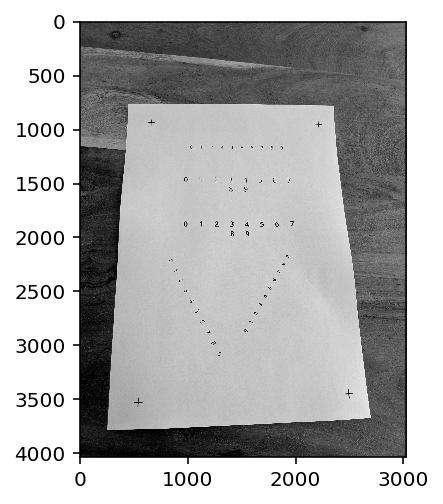

In [6]:
plt.imshow(test_page_img, cmap='gray');

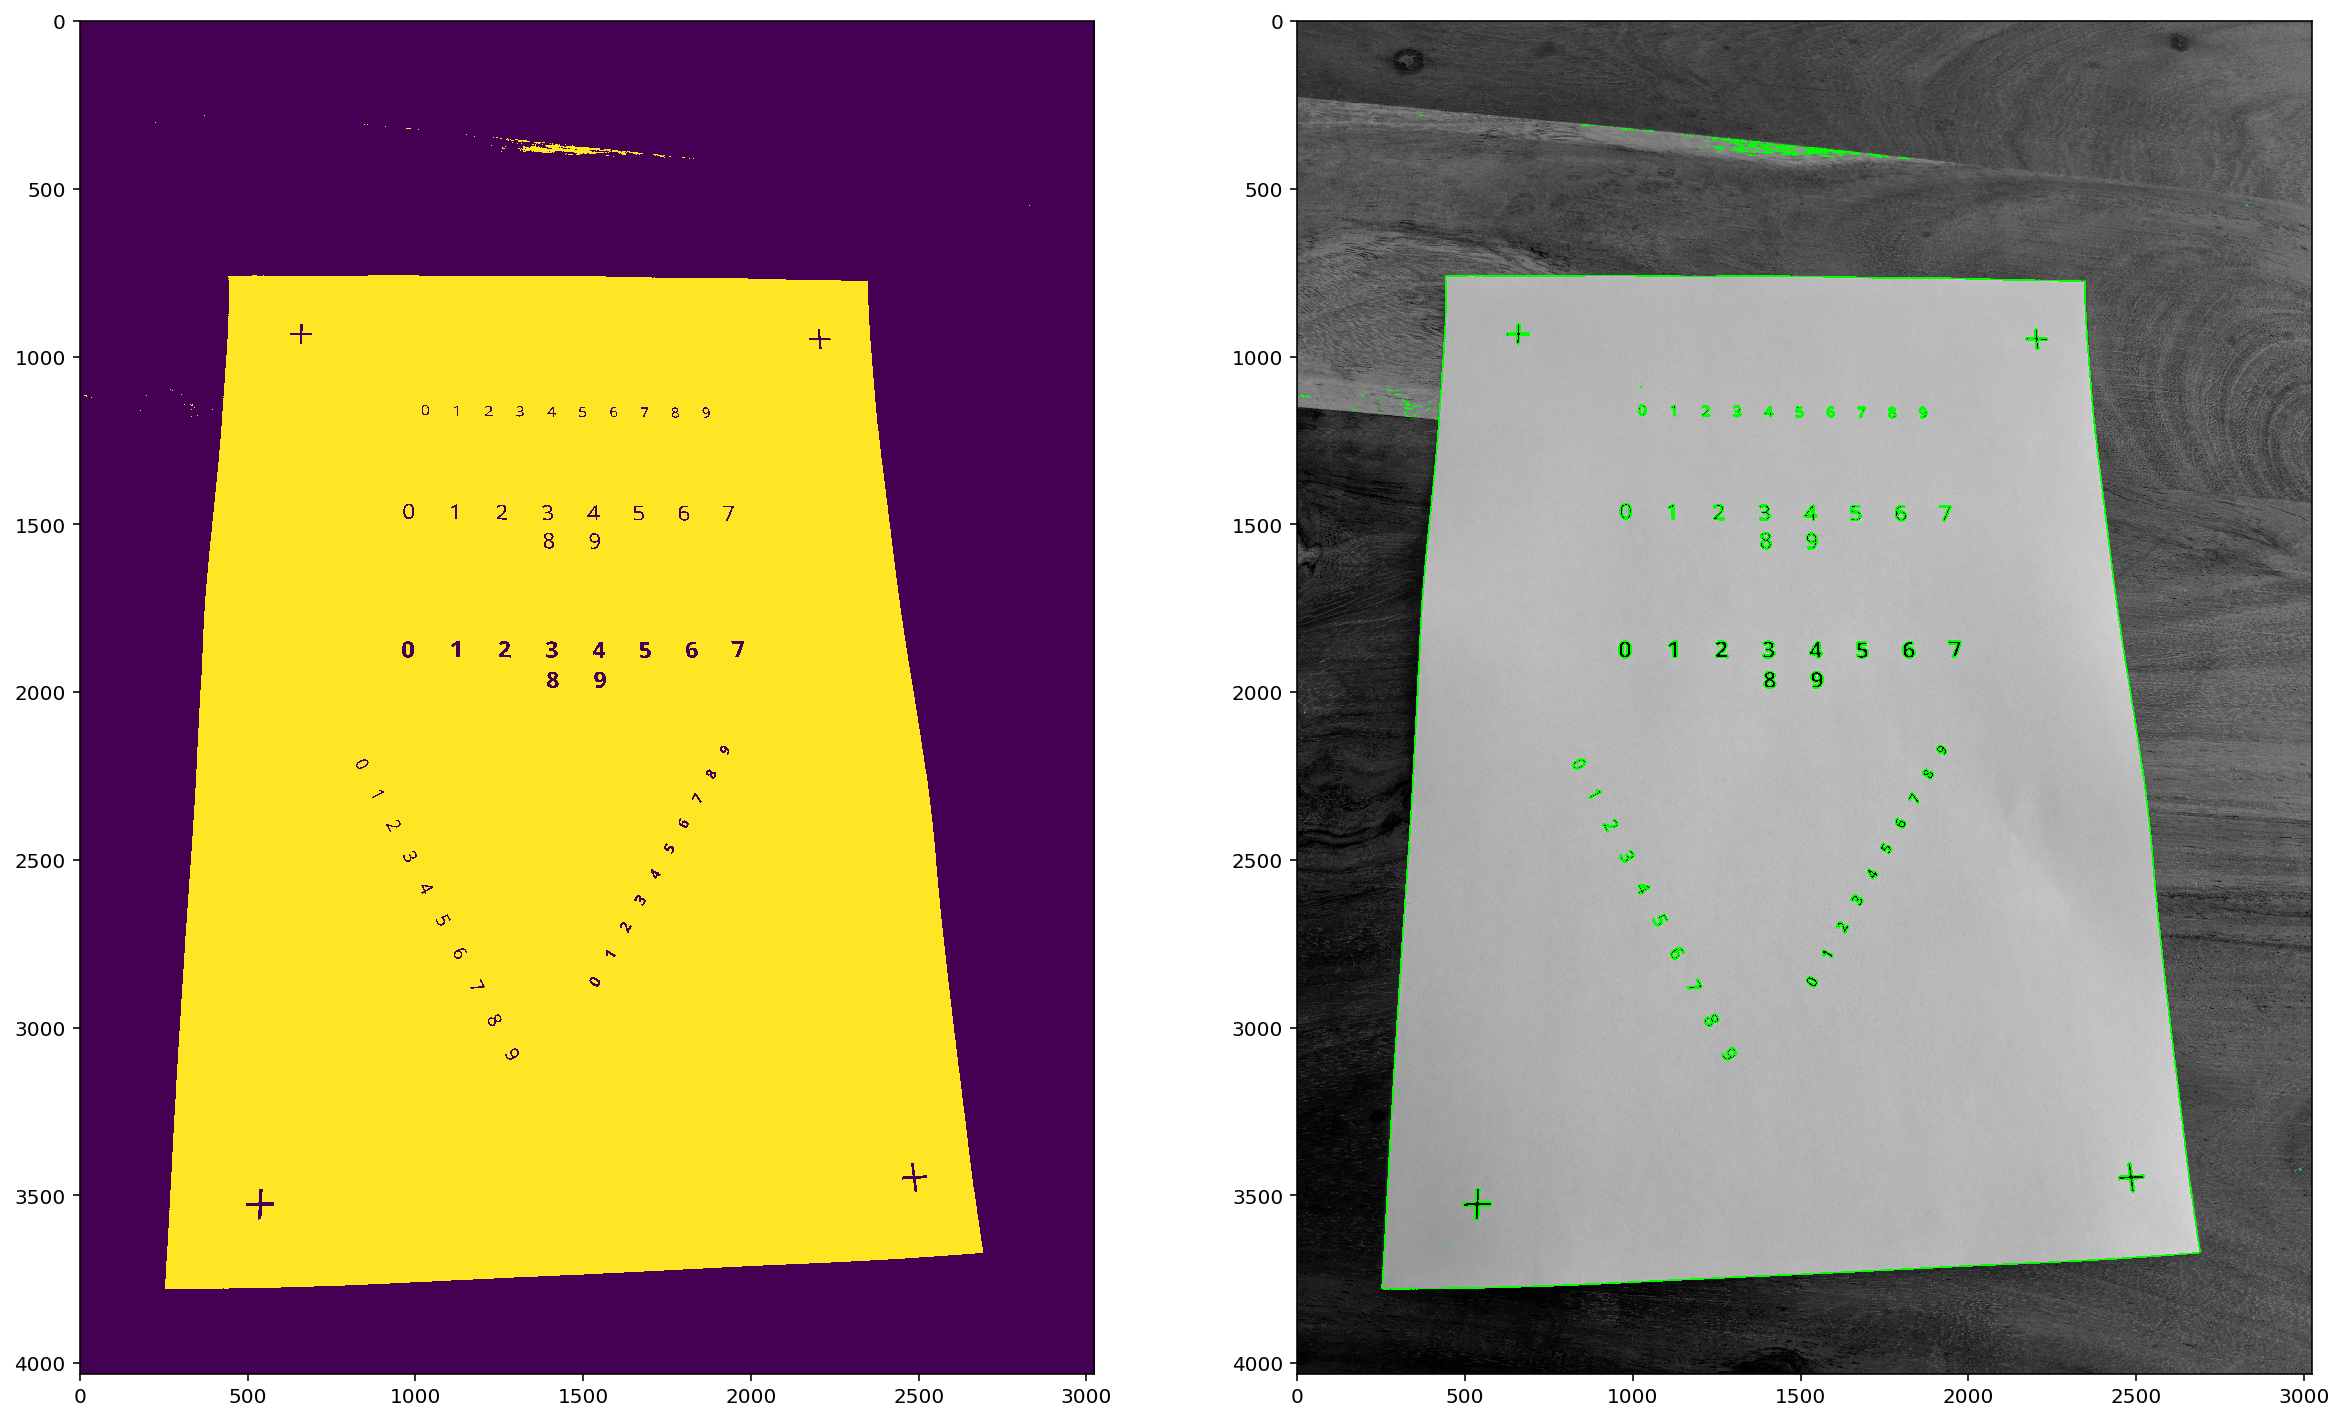

In [10]:
ret, thresh = cv2.threshold(test_page_img, 140, 255, cv2.THRESH_BINARY)
contours, h = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
res = cv2.cvtColor(test_page_img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(res, contours, -1, (0,255,0), 3);

fig, ax = plt.subplots(ncols=2, figsize=(20, 20))
ax[0].imshow(thresh); ax[1].imshow(res);
plt.show()

array([[ 537.5, 3526. ],
       [2485.5, 3446.5],
       [2204.5,  948. ],
       [ 658.5,  933. ]])

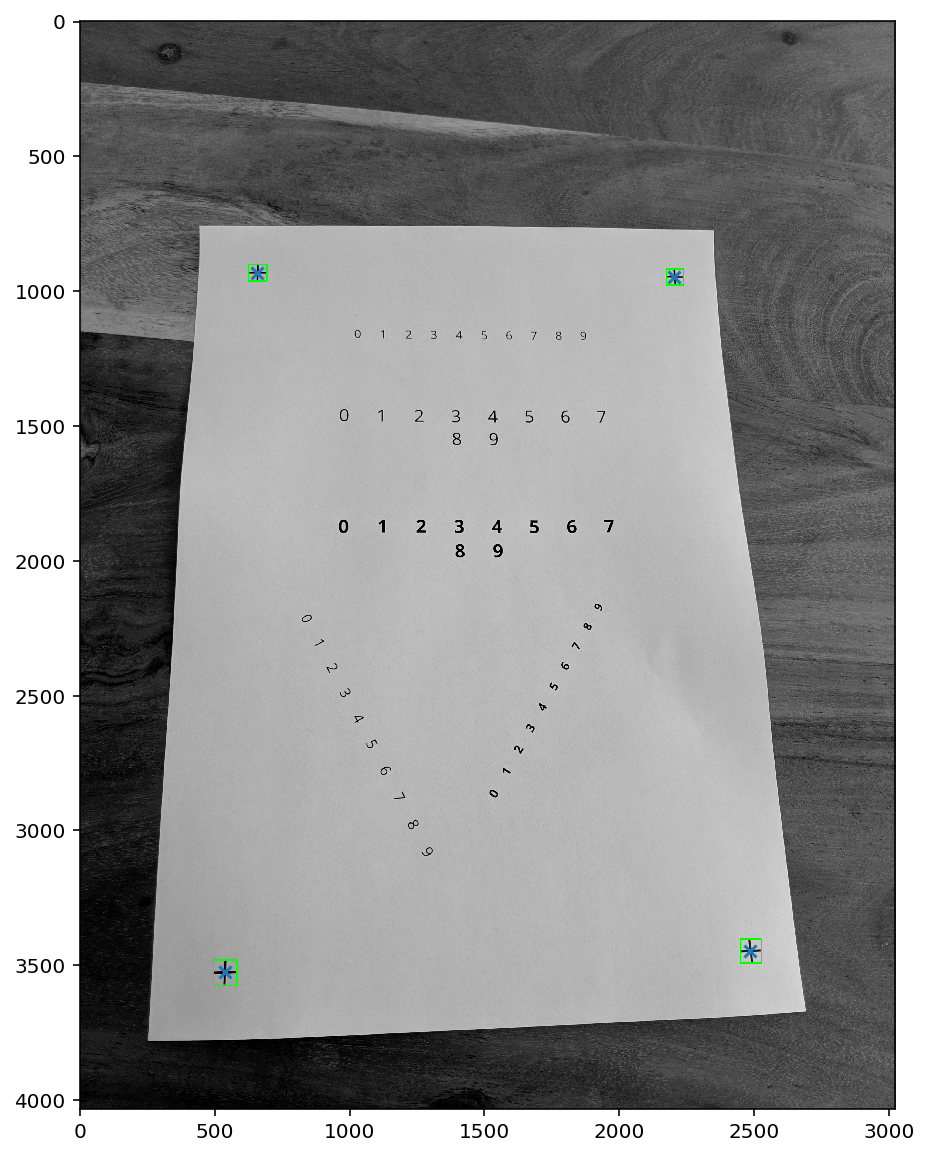

In [11]:
res = cv2.cvtColor(test_page_img, cv2.COLOR_GRAY2BGR)

cross_cords = []
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 50 and w < 100:
        cross_cords += [[x+w/2, y+h/2]]
        cv2.rectangle(res, (x,y), (x+w, y+h), (0, 255, 0), 4)
       
cross_cords = np.array(cross_cords)
plt.figure(figsize=(20,10))
plt.imshow(res);
plt.scatter(cross_cords[:, 0], cross_cords[:, 1], marker='x')

cross_cords

In [12]:
""" 
source of code in this cell:
https://github.com/KMKnation/Four-Point-Invoice-Transform-with-OpenCV/blob/master/four_point_object_extractor.py
"""

def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def four_point_transform(pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    M = cv2.getPerspectiveTransform(rect, dst)
    return M, (maxWidth, maxHeight)

In [13]:
M, dims = four_point_transform(cross_cords)
warped = cv2.warpPerspective(test_page_img, M, dims)

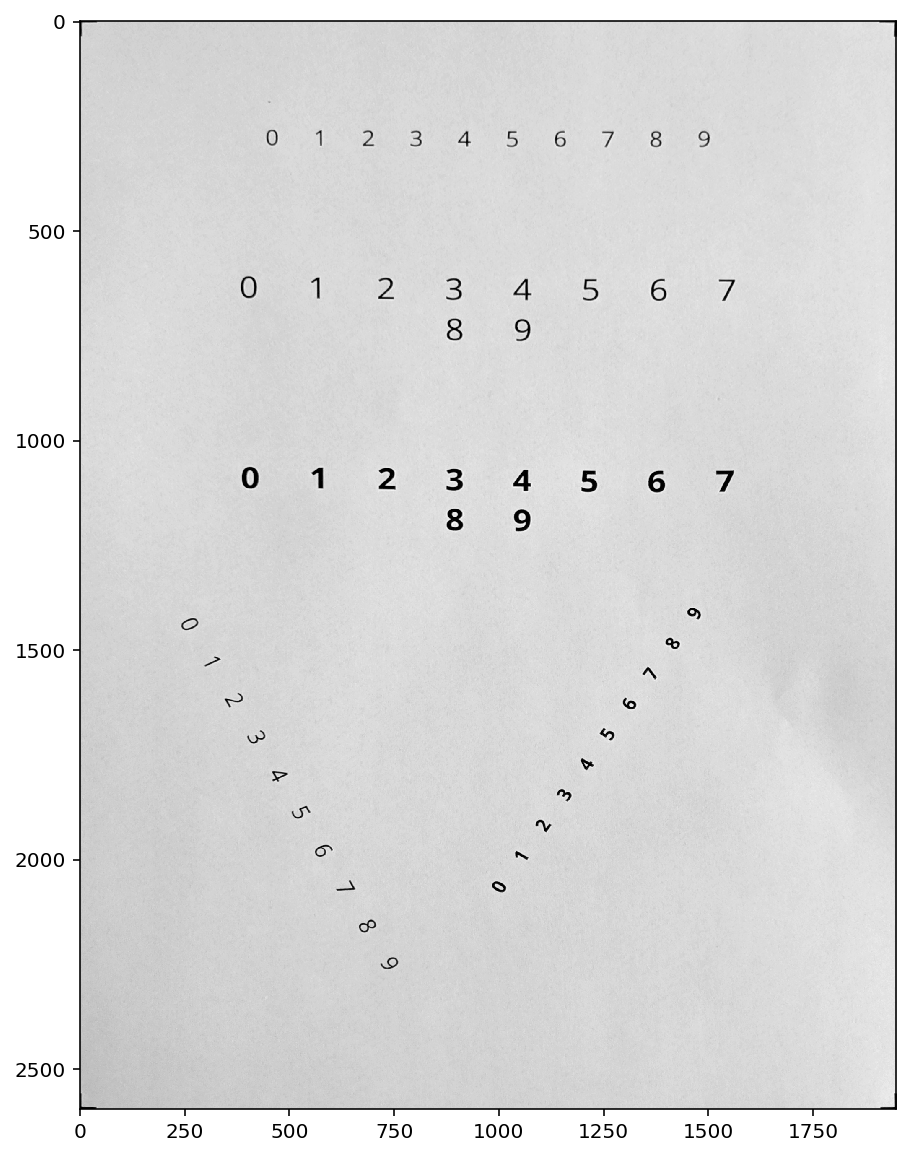

In [14]:
plt.figure(figsize=(20, 10))
plt.imshow(warped, cmap='gray')

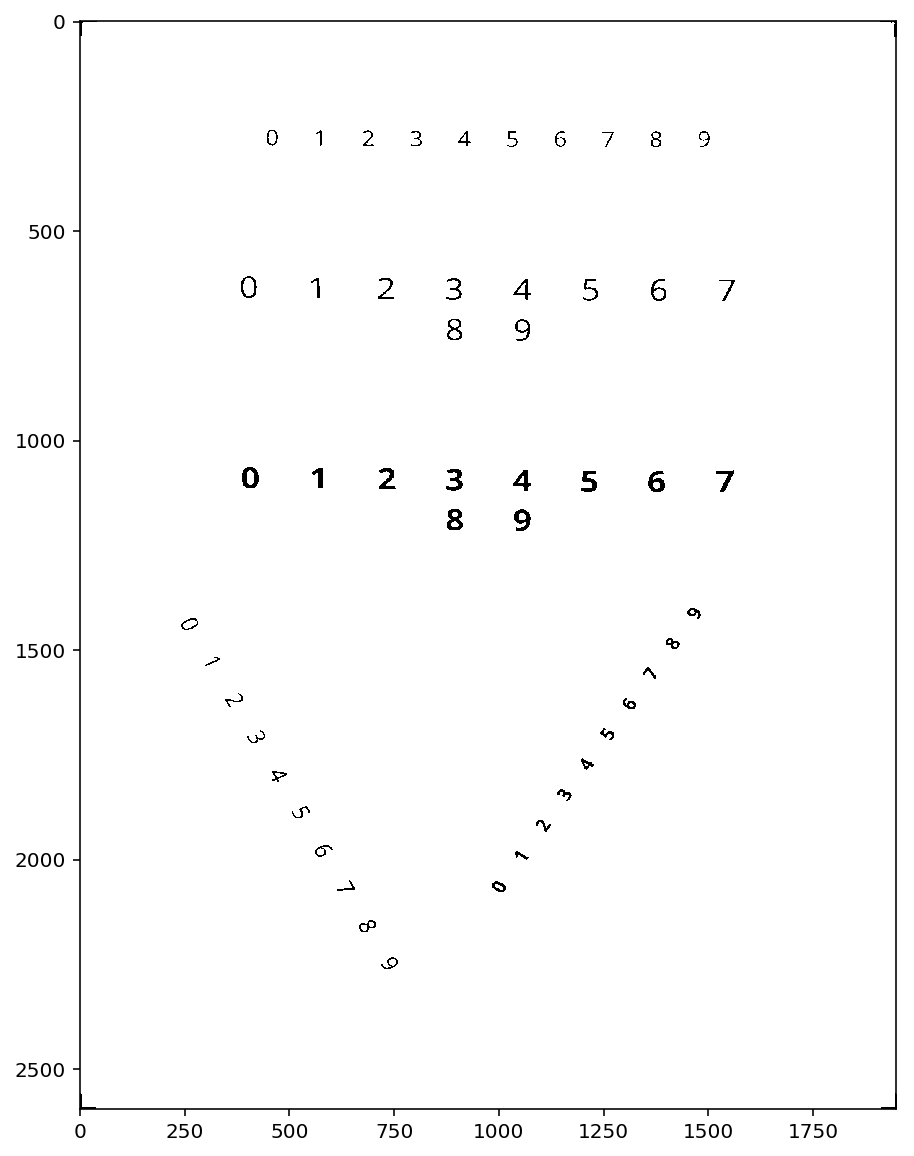

In [27]:
_, warped_thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.figure(figsize=(20, 10)); plt.imshow(warped_thresh, cmap='gray');

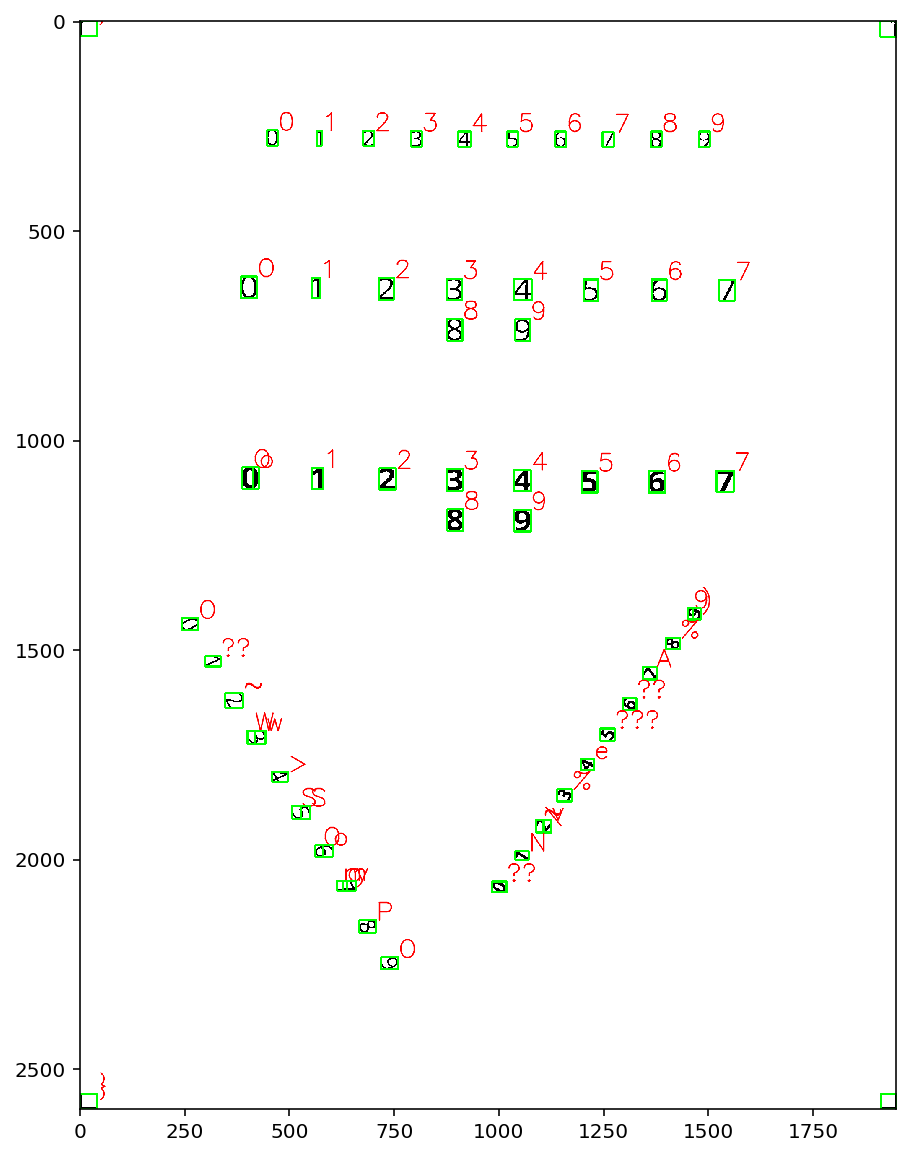

In [52]:
# https://github.com/tesseract-ocr/tesseract/wiki/ImproveQuality
#  4     Assume a single column of text of variable sizes.
#  6     Assume a single uniform block of text.
#  11    Sparse text. Find as much text as possible in no particular order.
boxes = pytesseract.image_to_boxes(warped_thresh, config='--psm 6')

res_detec = cv2.cvtColor(warped_thresh, cv2.COLOR_GRAY2BGR)
h, w, _ = res_detec.shape

for b in boxes.splitlines():
    b = b.split(' ')
    res_detec = cv2.putText(res_detec, b[0], (int(b[3]), h - int(b[4])), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2, cv2.LINE_AA)
    res_detec = cv2.rectangle(res_detec, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 4)

plt.figure(figsize=(20, 10))
plt.imshow(res_detec)